In [1]:
import torch

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from keras import layers
from keras.utils.vis_utils import plot_model

import numpy as np
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
directory_train = 'data\\Train'
directory_validation = 'data\\Val'
directory_testing = "data\\Test"

In [3]:
batch_size = 8
h, w = 331, 331

train_gen = ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip=True,
    vertical_flip=True
)

val_test_gen = ImageDataGenerator(
    rescale=1./255.
)

In [4]:
train_data = train_gen.flow_from_directory(
    directory=directory_train,
    color_mode="rgb",
    target_size=(h, w),
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True
)

val_data = val_test_gen.flow_from_directory(
    directory=directory_validation,
    color_mode="rgb",
    target_size=(h, w),
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False
)

test_data = val_test_gen.flow_from_directory(
    directory=directory_testing,
    color_mode="rgb",
    target_size=(h, w),
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False
)

Found 228 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [5]:
imgs, labels = next(train_data)
print("Images Shape: ", imgs.shape)
print("Labels: ", labels[:5])

Images Shape:  (8, 331, 331, 3)
Labels:  [[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


Classes:  ['Covid', 'Normal']


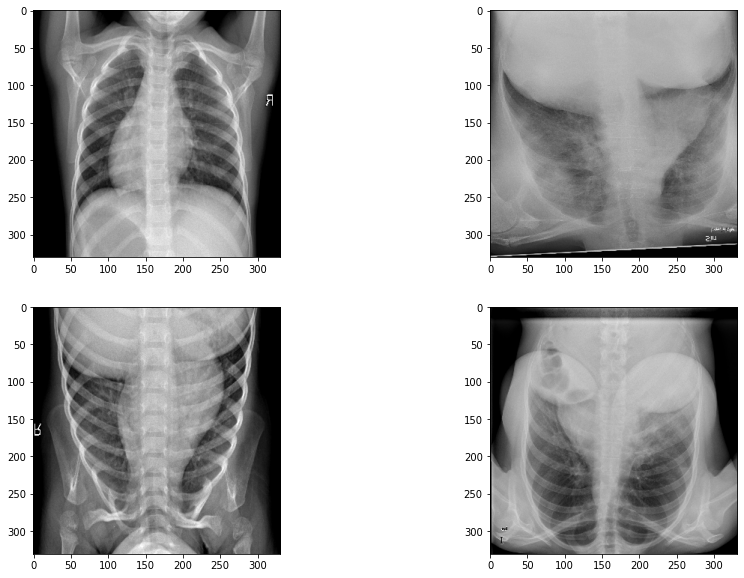

In [6]:
classes = train_data.class_indices
classes = list(classes.keys())
print("Classes: ", classes)

def plot_imgs(img, labels):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
    img_index = 0
    for i in range(2):
        for j in range(2):
            ax[i][j].imshow(img[img_index])
            img_label = np.argmax(labels[img_index])
            img_index += 1

plot_imgs(imgs, labels)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 9, 9, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1573888   
                                                                 
 dense_1 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 55,912,674
Trainable params: 1,575,938
Non-trainable params: 54,336,736
_________________________________________________________________


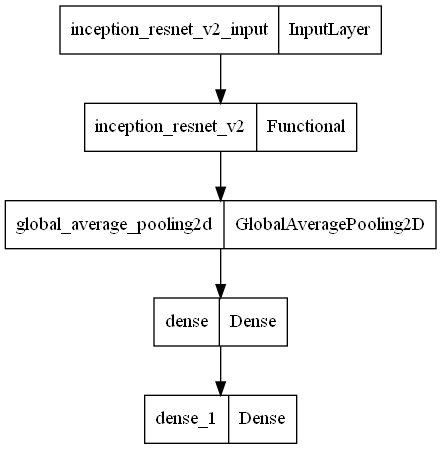

In [7]:
def get_model():
    base_model = InceptionResNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(h, w, 3)    
    )

    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation="relu"),
        layers.Dense(2, activation="softmax")
    ])

    return model

model = get_model()
model.summary()
plot_model (model, to_file='model_plot.png', show_layer_names=True)

In [8]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
history = model.fit(train_data, validation_data=val_data, epochs=30, batch_size=batch_size)

Epoch 1/30
29/29 [==============================] - 22s 389ms/step - loss: 0.4213 - accuracy: 0.8904 - val_loss: 0.1406 - val_accuracy: 0.9333
Epoch 2/30
29/29 [==============================] - 7s 234ms/step - loss: 0.2074 - accuracy: 0.9518 - val_loss: 0.1803 - val_accuracy: 0.9667
Epoch 3/30
29/29 [==============================] - 7s 228ms/step - loss: 0.0751 - accuracy: 0.9825 - val_loss: 0.0079 - val_accuracy: 1.0000
Epoch 4/30
29/29 [==============================] - 7s 234ms/step - loss: 0.0383 - accuracy: 0.9956 - val_loss: 0.0552 - val_accuracy: 0.9833
Epoch 5/30
29/29 [==============================] - 7s 235ms/step - loss: 0.0745 - accuracy: 0.9825 - val_loss: 0.0178 - val_accuracy: 0.9833
Epoch 6/30
29/29 [==============================] - 7s 233ms/step - loss: 0.0808 - accuracy: 0.9825 - val_loss: 0.0281 - val_accuracy: 0.9833
Epoch 7/30
29/29 [==============================] - 7s 232ms/step - loss: 0.0810 - accuracy: 0.9737 - val_loss: 0.1054 - val_accuracy: 0.9833
Epoch

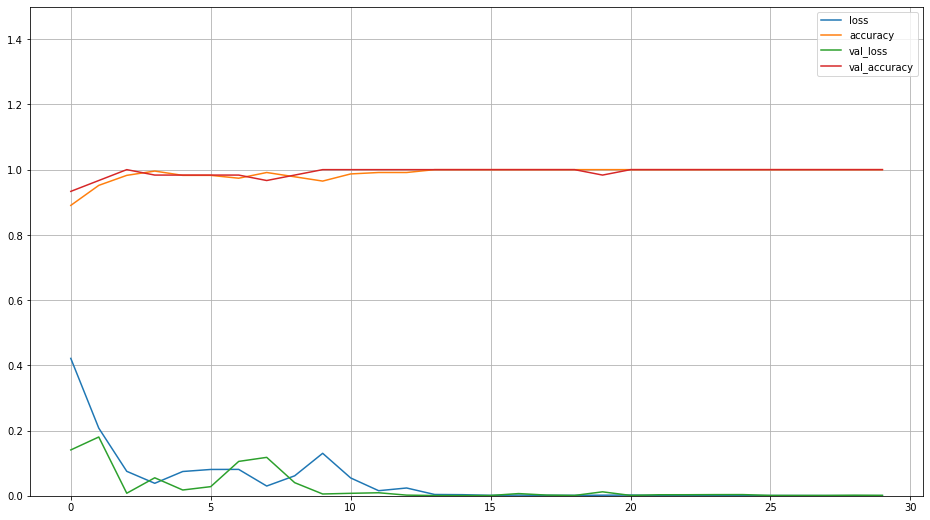

In [10]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(16, 9))
plt.grid(True)
plt.gca().set_ylim(0, 1.5)
plt.show()

In [11]:
accuracy_score = model.evaluate(test_data)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))

print("Loss: ",accuracy_score[0])

8/8 [==============================] - 2s 156ms/step - loss: 0.0550 - accuracy: 0.9833
[0.05498076230287552, 0.9833333492279053]
Accuracy: 98.3333%
Loss:  0.05498076230287552


8/8 [==============================] - 4s 158ms/step


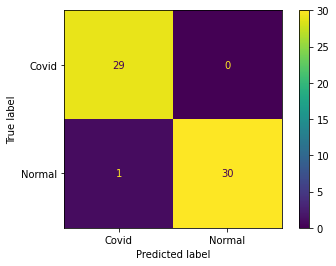

In [12]:
labels = ["Covid", "Normal"]

preds = model.predict(test_data, verbose=1)
preds_labels = np.argmax(preds, axis=1)
gr_th = test_data.classes

cm = confusion_matrix(preds_labels, gr_th)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

In [13]:
model.save_weights("final_inception_resnet_v3.h5")

# Test Model Using Saved Weights

In [14]:
model = get_model()
model.load_weights("final_inception_resnet_v3.h5")
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
accuracy_score = model.evaluate(test_data)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))

print("Loss: ",accuracy_score[0])

8/8 [==============================] - 6s 151ms/step - loss: 0.0550 - accuracy: 0.9833
[0.05498076230287552, 0.9833333492279053]
Accuracy: 98.3333%
Loss:  0.05498076230287552


8/8 [==============================] - 4s 157ms/step


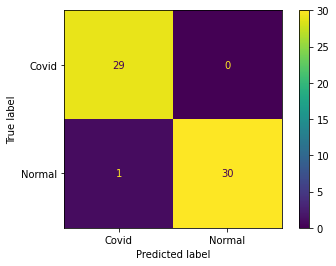

In [16]:
labels = ["Covid", "Normal"]

preds = model.predict(test_data, verbose=1)
preds_labels = np.argmax(preds, axis=1)
gr_th = test_data.classes

cm = confusion_matrix(preds_labels, gr_th)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()